In [2]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
# import s2fft

import micmac as micmac

In [4]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_LiteBIRD_64 import *

In [5]:
working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'


In [6]:
file_ver = 'biased_masked_full_v100_Gchain_SO_64_v1d' # -> WF&Fluct v2 + 2500 iterations + mask + 1% error + biased_full_chain_v1c ; C_approx only lensing
path_toml_file = directory_toml_file + 'biased_full_chain_v1c.toml'

In [7]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [8]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [9]:
input_cmb_maps.shape

(6, 2, 49152)

In [10]:
cmb_map_to_test = input_cmb_maps[0,:,:]

In [12]:
cmb_map_to_test = np.vstack((np.zeros_like(cmb_map_to_test[0]), cmb_map_to_test))

In [13]:
cmb_map_to_test.shape

(3, 49152)

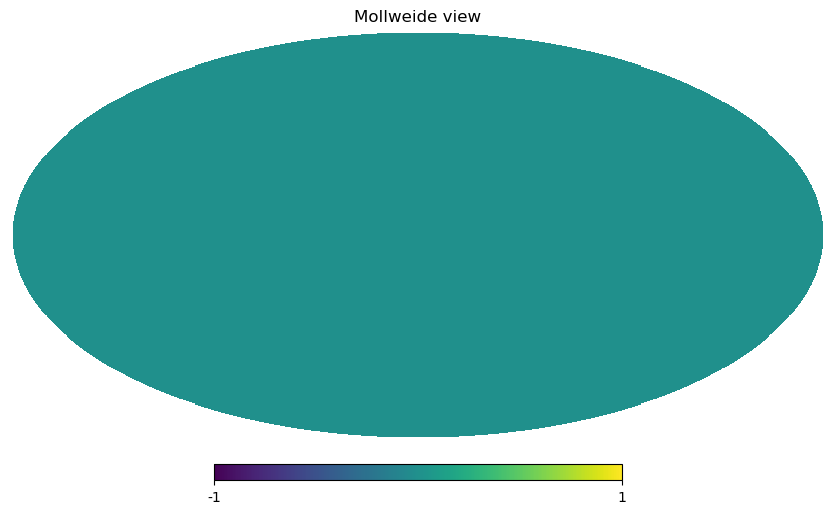

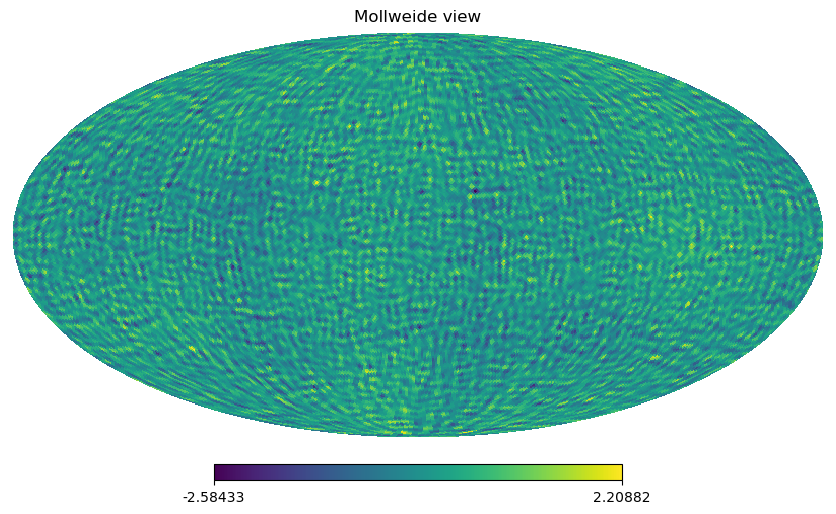

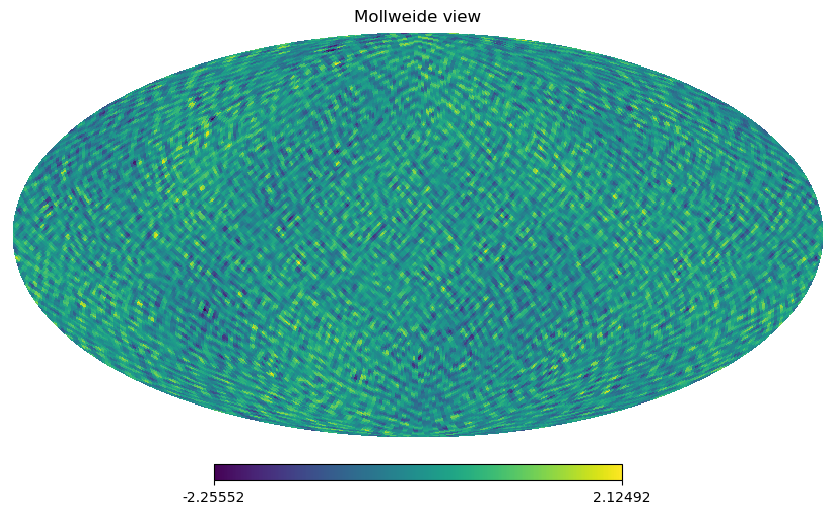

In [14]:
for i in range(3):
    hp.mollview(cmb_map_to_test[i])

In [46]:
cls_HP = hp.anafast(cmb_map_to_test, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)

In [104]:
# spin_2_field = cmb_map_to_test[1]+cmb_map_to_test[2]
# spin_m2_field = cmb_map_to_test[1]-1j*cmb_map_to_test[2]
spin_2_field = cmb_map_to_test[1]+cmb_map_to_test[2]
spin_m2_field = 1j*(cmb_map_to_test[1]-cmb_map_to_test[2])
spin_2_field = cmb_map_to_test[1]
spin_m2_field = cmb_map_to_test[1]

flm_2_Q = s2fft.forward_jax(np.array([spin_2_field]), L=128, nside=MICMAC_sampler_obj.nside, spin=2)
flm_m2_Q = s2fft.forward_jax(np.array([spin_m2_field]), L=128, nside=MICMAC_sampler_obj.nside, spin=-2)

flm_2_U = s2fft.forward_jax(np.array([cmb_map_to_test[2]]), L=128, nside=MICMAC_sampler_obj.nside, spin=2)
flm_m2_U = s2fft.forward_jax(np.array([cmb_map_to_test[2]]), L=128, nside=MICMAC_sampler_obj.nside, spin=-2)

In [94]:
flm_2.shape

(128, 255)

In [115]:
alm_E = -.5*(flm_2_Q + flm_m2_U)
alm_B = -.5*1j*(flm_2 - flm_m2)

attempt_cls = jnp.linalg.norm(alm_E,ord=2,axis=1)**2/(2*np.arange(0,flm_2.shape[0])+1)

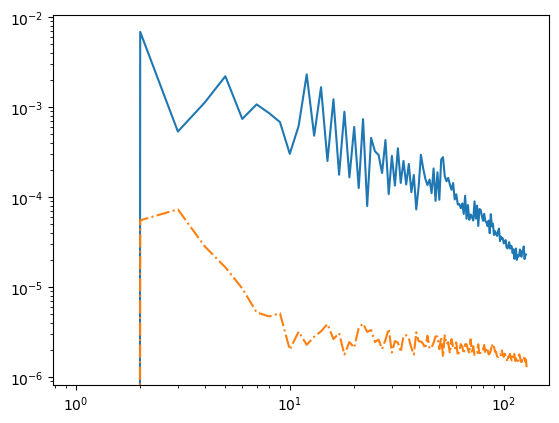

In [116]:
ell_arange = np.arange(0,flm_2.shape[0]+1)

plt.plot(ell_arange[:-1], attempt_cls)
plt.plot(ell_arange, cls_HP[2,:], '-.')
plt.loglog()
plt.show()